# Kaggle Spaceship Titanic Competition
***
Team 7:
- John Peter Bergmann
- Meng-Shan Ho
- Gabriela Mata Lopez
- Alexis Saidi
- Marco Filippone Valenti

In [1]:
# Imports

import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

filterwarnings("ignore")
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle, resample
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier

from tqdm import tqdm

import os
import tensorflow as tf

SEED = 42
np.random.seed(SEED)

Before we begin:
- For comparability, a **SEED** variable is set and used whenever possible (exception: deeplearning)
- The main evaluation metric used in this notebook is **accuracy**. This is due to the fact that the competition itself promotes this score. Nonetheless, confusion matrices are visualized to show model performance and allow further interpretation into FPR, TPR etc. if one wishes.

In [2]:
def save_df(data, location):
    """
    Utility function to save dataframe with predictions as csv file.
    Expects directory called "Predictions" to exist in the current working directory.

    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe to be saved.
    location : str
        Name of the subdirectory to save the file in.
    """
    
    version = 0
    filename = f"Predictions/{location}/v{version}.csv"

    # Check if the file already exists
    while os.path.isfile(filename):
        version += 1
        filename = f"Predictions/{location}/v{version}.csv"

    data.to_csv(filename, index=False)

    return f"Data written to file: {filename}"

### train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

| Features | Description |
| -------- | ----------- |
| PassengerId | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| HomePlanet | The planet the passenger departed from, typically their planet of permanent residence. |
| CryoSleep | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| Cabin | The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| Destination | The planet the passenger will be debarking to. |
| Age | The age of the passenger. |
| VIP | Whether the passenger has paid for special VIP service during the voyage. |
| RoomService, FoodCourt, ShoppingMall, Spa, VRDeck | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| Name | The first and last names of the passenger. |
| Transported | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

### test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

### sample_submission.csv - A submission file in the correct format.

**PassengerId** - Id for each passenger in the test set. <br>
**Transported** - The target. For each passenger, predict either True or False.

# Read data


In [3]:
train = pd.read_csv("DATA/train.csv")
test = pd.read_csv("DATA/test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [7]:
# identify which columns are categorical
for col in train.columns:
    print(f"{col} has {len(train[col].value_counts())} different categories")

PassengerId has 8693 different categories
HomePlanet has 3 different categories
CryoSleep has 2 different categories
Cabin has 6560 different categories
Destination has 3 different categories
Age has 80 different categories
VIP has 2 different categories
RoomService has 1273 different categories
FoodCourt has 1507 different categories
ShoppingMall has 1115 different categories
Spa has 1327 different categories
VRDeck has 1306 different categories
Name has 8473 different categories
Transported has 2 different categories


In [8]:
# Inspect missing value counts
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [9]:
X = train.drop(columns=["Transported"])
y = train["Transported"].astype(int)

# Data Cleaning / EDA

In [10]:
# Check if target is balanced
y.value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

Our target variable is balanced. Let's move on

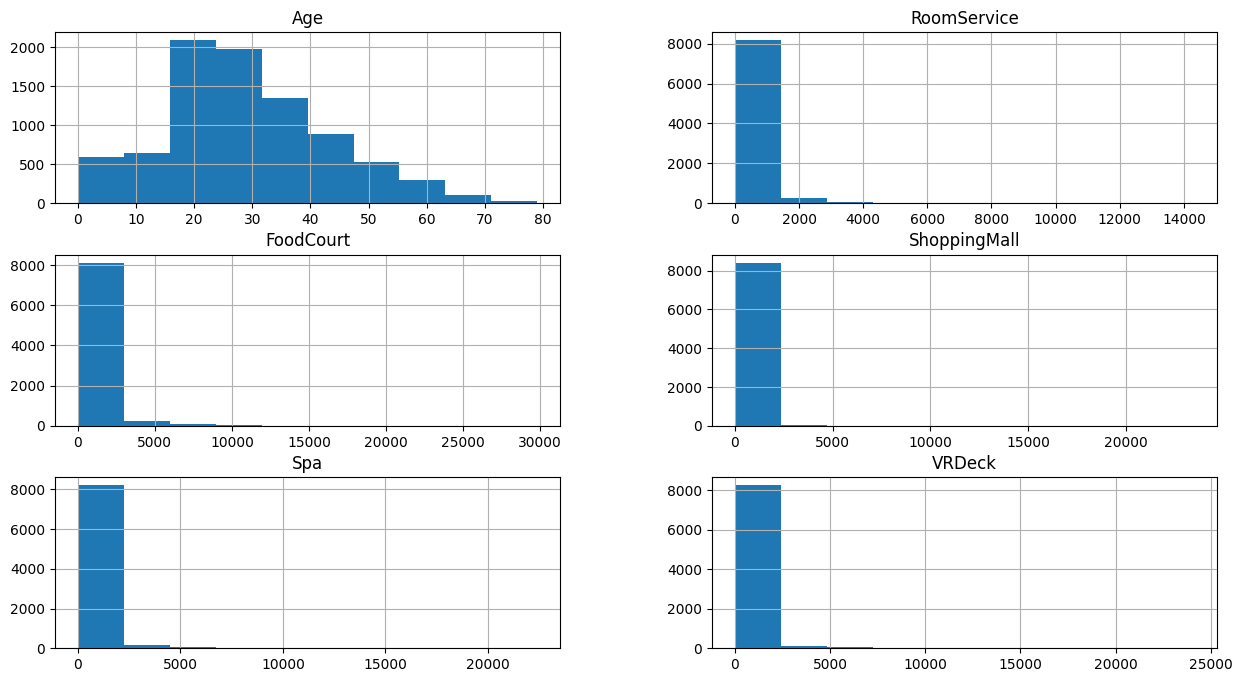

In [11]:
X.hist(figsize=(15,8));

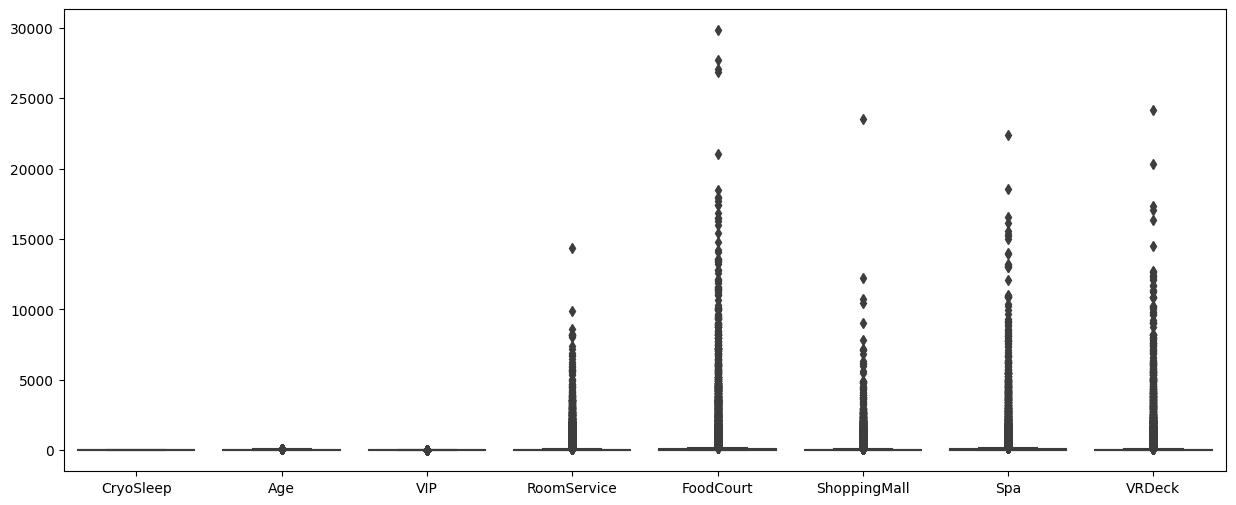

In [12]:
# Boxplot with longer x axis
plt.figure(figsize=(15,6))
sns.boxplot(X);

Outliers do appear to be present, however not to a great extend. It is possible that while statistically deemed outliers, these figures are more associated with VIP passengers who spend more money and don't havea negative influence on our model.

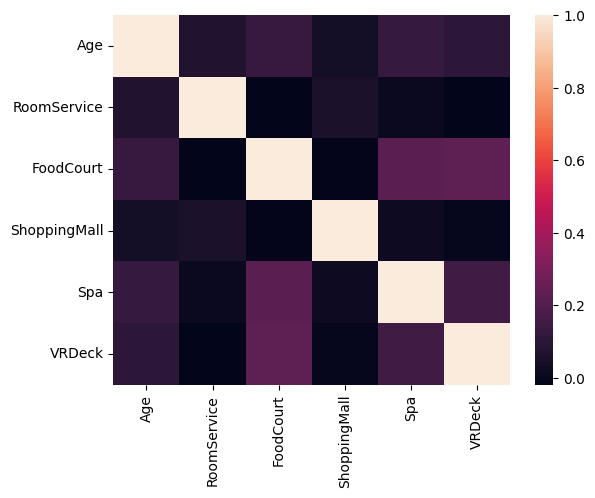

In [13]:
sns.heatmap(X.corr(numeric_only=True));

No multicollinearity appears to be present.

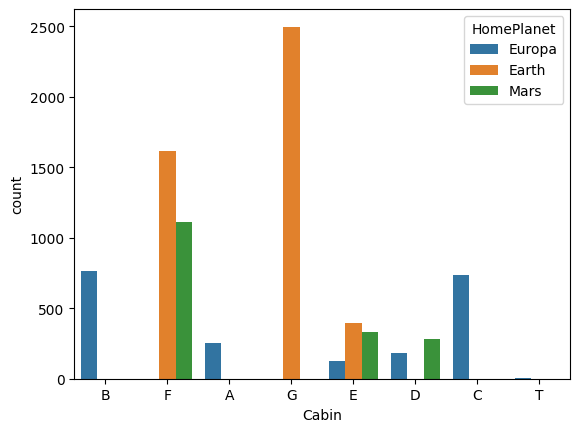

In [14]:
# See for each Cabin type what the homeplanet is
sns.countplot(x=X["Cabin"].str.split("/").str[0], hue="HomePlanet", data=X);

An interesting insight: All passengers travelling in Cabin Type "G" are from planet Earth. Furthermore, all travellers in Cabin Type "B", "A", "C", or "T" can be more specifically attributed to Europa.

# Feature Engineering/Selection

In [15]:
X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

Stratified Sampling ensures the target distribution remains the same in train and validation datasets. We also observe an increase in model performance.

In [17]:
def create_features(dataframe):
    """
    Function that creates new features from the existing features in the "Spaceship Titanic" training dataset.
    Partially inspired and adapted from: https://www.kaggle.com/code/vladisov/spaceship-titanic-using-fast-ai

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Dataframe to create new features for.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with new features added.
    """

    df = dataframe.copy()

    # Numerical feature creation/transformation
    df["LogRoomService"] = np.log1p(df["RoomService"])
    df["LogFoodCourt"] = np.log1p(df["FoodCourt"])
    df["LogShoppingMall"] = np.log1p(df["ShoppingMall"])
    df["LogSpa"] = np.log1p(df["Spa"])
    df["LogVRDeck"] = np.log1p(df["VRDeck"])

    df.loc[(df["LogRoomService"].isna()) & (df["CryoSleep"] == True), "LogRoomService"] = 0.0
    df.loc[(df["LogFoodCourt"].isna()) & (df["CryoSleep"] == True), "LogFoodCourt"] = 0.0
    df.loc[(df["LogShoppingMall"].isna()) & (df["CryoSleep"] == True), "LogShoppingMall"] = 0.0
    df.loc[(df["LogSpa"].isna()) & (df["CryoSleep"] == True), "LogSpa"] = 0.0
    df.loc[(df["LogVRDeck"].isna()) & (df["CryoSleep"] == True), "LogVRDeck"] = 0.0

    df.loc[(df["RoomService"].isna()) & (df["CryoSleep"] == True), "RoomService"] = 0.0
    df.loc[(df["FoodCourt"].isna()) & (df["CryoSleep"] == True), "FoodCourt"] = 0.0
    df.loc[(df["ShoppingMall"].isna()) & (df["CryoSleep"] == True), "ShoppingMall"] = 0.0
    df.loc[(df["Spa"].isna()) & (df["CryoSleep"] == True), "Spa"] = 0.0
    df.loc[(df["VRDeck"].isna()) & (df["CryoSleep"] == True), "VRDeck"] = 0.0

    df["LogTotalSpend"] = (df["LogRoomService"] + df["LogFoodCourt"] + df["LogShoppingMall"] + df["LogSpa"] + df["LogVRDeck"])
    df["TotalSpent"] = (df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"])
    df["NoSpending"] = (df["TotalSpent"] == 0).astype(str)

    # Cabin Features
    df[["Cabin_Deck", "Cabin_Num", "Cabin_Side"]] = df["Cabin"].str.split("/", expand=True)
    df["Cabin_Size"] = df.groupby("Cabin")["Cabin"].transform("count")

    # Age Groups (String)
    age_bins = [0, 2, 12, 18, 26, 39, 59, df["Age"].max()]
    age_labels = ["Infant", "Child", "Teenager", "Young Adult", "Adult", "Middle Aged", "Senior"]
    df["Age_Group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, include_lowest=True).astype(str)

    # Passenger Groups
    df["PassengerGroup"] = df["PassengerId"].str.split("_", expand=True)[0]
    df["GroupSize"] = df.groupby("PassengerGroup")["PassengerGroup"].transform("count")

    # NA's
    df.loc[(df["CryoSleep"].isna()) & (df["TotalSpent"] > 0), "CryoSleep"] = False  # Cant spend money if you are in cryosleep
    df.loc[(df["CryoSleep"].isna()) & (df["TotalSpent"] == 0), "CryoSleep"] = True  # If you haven't spent money you are very likely in cryosleep

    df.loc[(df["HomePlanet"].isna()) & (df["Cabin_Deck"] == "G"), "HomePlanet"] = "Earth" # All G deck passengers are from Earth (see EDA)
    df.loc[(df["HomePlanet"].isna()) & (df["Cabin_Deck"].isin(["B", "A", "C", "T"])), "HomePlanet"] = "Europa" # All B, A, C, T deck passengers are from Europa (see EDA)

    df = df.drop(columns=["Cabin", "PassengerId", "Name", "Age", "PassengerGroup", "Cabin_Num"])

    return df


In [18]:
X_train, X_val, X_test = create_features(X_train), create_features(X_val), create_features(test)

In [19]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6954, 22), (1739, 22), (6954,), (1739,))

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 3600 to 7925
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HomePlanet       6864 non-null   object 
 1   CryoSleep        6935 non-null   object 
 2   Destination      6801 non-null   object 
 3   VIP              6796 non-null   object 
 4   RoomService      6867 non-null   float64
 5   FoodCourt        6860 non-null   float64
 6   ShoppingMall     6863 non-null   float64
 7   Spa              6861 non-null   float64
 8   VRDeck           6860 non-null   float64
 9   LogRoomService   6867 non-null   float64
 10  LogFoodCourt     6860 non-null   float64
 11  LogShoppingMall  6863 non-null   float64
 12  LogSpa           6861 non-null   float64
 13  LogVRDeck        6860 non-null   float64
 14  LogTotalSpend    6508 non-null   float64
 15  TotalSpent       6508 non-null   float64
 16  NoSpending       6954 non-null   object 
 17  Cabin_Deck 

In [21]:
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

In [22]:
class IQRTransformer(BaseEstimator, TransformerMixin):
    """
    Sklearn transformer that handles outliers from numerical features using the IQR method.

    Parameters
    ----------
    handle : str, optional
        How to handle the outliers:
        If None, no action is taken. 
        If "bound", the outliers are bounded to the upper and lower bound.
        If "replace", the outliers are replaced with NaNs (to be handled by the SimpleImputer).
    """

    def __init__(self, handle=None):
        self.handle = handle

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        num_cols = X.select_dtypes(include=np.number).columns

        if not self.handle:
            return X
        
        for col in num_cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            S = 1.5 * IQR
            LB = Q1 - S
            UB = Q3 + S

            if self.handle == "replace":
                X.loc[X[col] > UB, col] = np.nan
                X.loc[X[col] < LB, col] = np.nan

            elif self.handle == "bound":
                X.loc[X[col] > UB, col] = UB
                X.loc[X[col] < LB, col] = LB

        return X

In [23]:
transformer_num_pipe = Pipeline(
    [("Impute", SimpleImputer(strategy="median"))]
)

transformer_ohe_cat_pipe = Pipeline(
    [
        ("Impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(sparse_output=False)),
    ]
)

In [24]:
transformer = ColumnTransformer(
    [
        ("Numeric", transformer_num_pipe, num_cols),
        ("Categorical_OHE", transformer_ohe_cat_pipe, cat_cols),
    ],
    remainder="passthrough",
)


In [25]:
prep = Pipeline(
    [
        ("IQR", IQRTransformer("bound")),
        ("Preprocessing", transformer),
        ("Feature_Selection", VarianceThreshold(0)),
        ("Scaler", MinMaxScaler()),
    ])

In [26]:
X_train, y_train = prep.fit_transform(X_train), y_train.values
X_val, y_val = prep.transform(X_val), y_val.values
X_test = prep.transform(X_test)

In [27]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((6954, 44), (6954,), (1739, 44), (1739,), (4277, 44))

# Model Training

## Baseline Models
The baseline models and corresponding pipeline have been set up intuitively to:
- Impute NAN values using the median (numeric) and mode (categorical)
- One-Hot Encode categorcial variables (none in the dataset have obvious ordinal structure)
- Bind outliers to the respective upper and lower bound of the IQR range
- Remove any features with variance of 0 (if they exist)
- Normalize data using MinMax Scaling (range 0, 1)

### Decision Tree

In [28]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)
tree.score(X_val, y_val)

0.7510063254744106

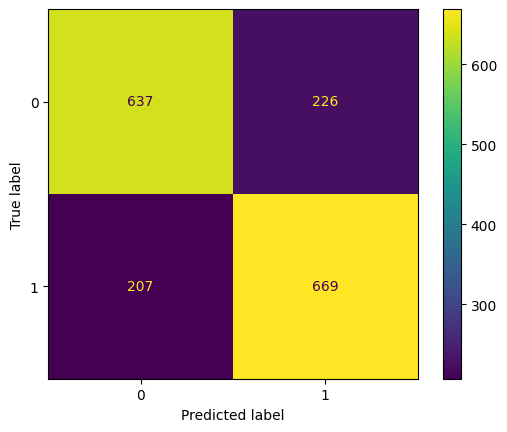

In [29]:
ConfusionMatrixDisplay.from_estimator(estimator=tree, X=X_val, y=y_val);

### Logistic Regression

In [30]:
log = LogisticRegression(random_state=SEED)
log.fit(X_train, y_train)
log.score(X_val, y_val)

0.7567567567567568

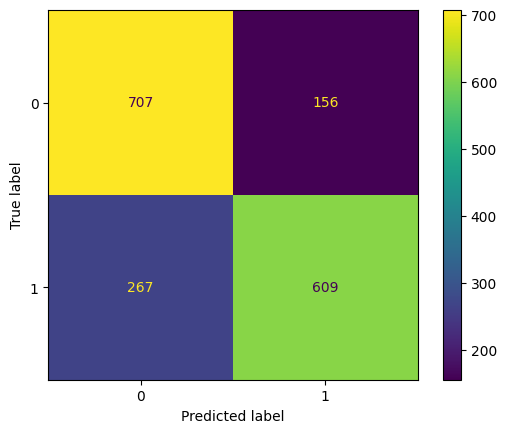

In [31]:
ConfusionMatrixDisplay.from_estimator(estimator=log, X=X_val, y=y_val);

### Random Forest

In [32]:
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

0.7883841288096607

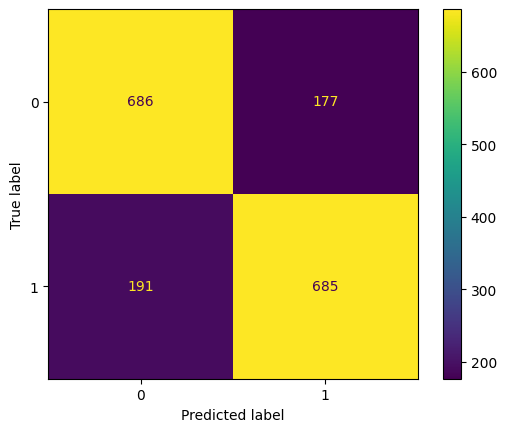

In [33]:
ConfusionMatrixDisplay.from_estimator(estimator=rf, X=X_val, y=y_val);

### SVM

In [34]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)
svm.score(X_val, y_val)

0.7814836112708453

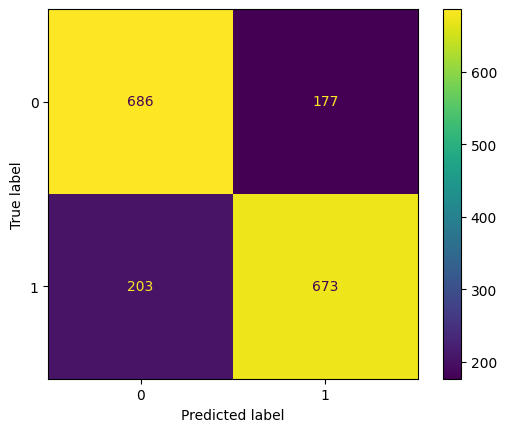

In [35]:
ConfusionMatrixDisplay.from_estimator(estimator=svm, X=X_val, y=y_val);

### Linear SVM (SGD)

In [36]:
l_svm = SGDClassifier(random_state=SEED)
l_svm.fit(X_train, y_train)
l_svm.score(X_val, y_val)

0.7366302472685451

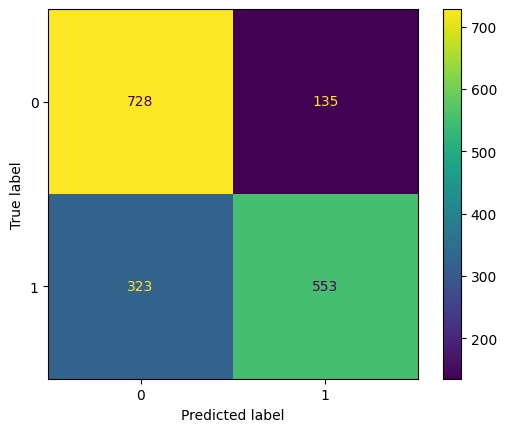

In [37]:
ConfusionMatrixDisplay.from_estimator(estimator=l_svm, X=X_val, y=y_val);

### XGBoost

In [38]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train, y_train)
xgb.score(X_val, y_val)

0.8039102932719954

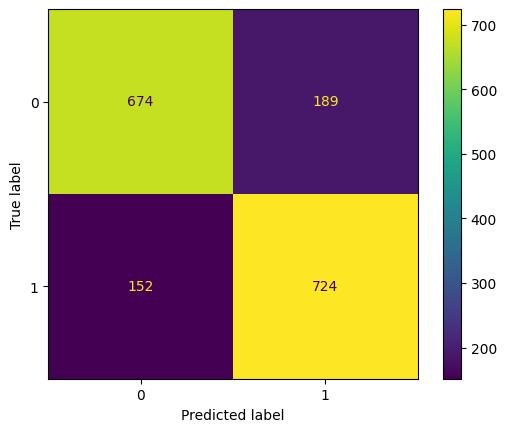

In [39]:
ConfusionMatrixDisplay.from_estimator(estimator=xgb, X=X_val, y=y_val);

### Cat Classifier

In [40]:
cat = CatBoostClassifier(random_state=SEED, verbose=False)
cat.fit(X_train, y_train)
cat.score(X_val, y_val)

0.8050603795284647

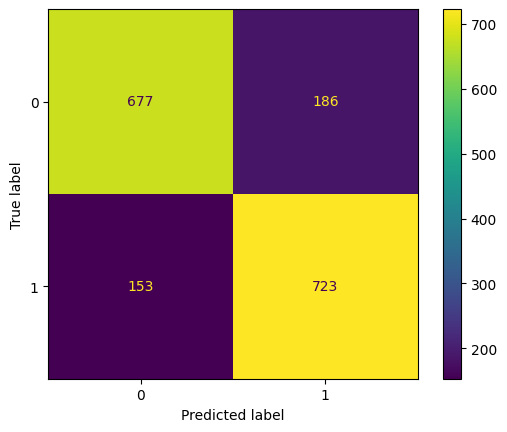

In [41]:
ConfusionMatrixDisplay.from_estimator(estimator=cat, X=X_val, y=y_val);

## Hyperparameter Tuning

### The most promising models (Random Forest, XGBoost, and CatBoost) are now tuned for optimal hyperparameters

Since the jupyter kernel can become quite unstable during longer Gridsearch training, GridSearch is performed in the file `Multimodel_Grid.py`.
The results are as follows:

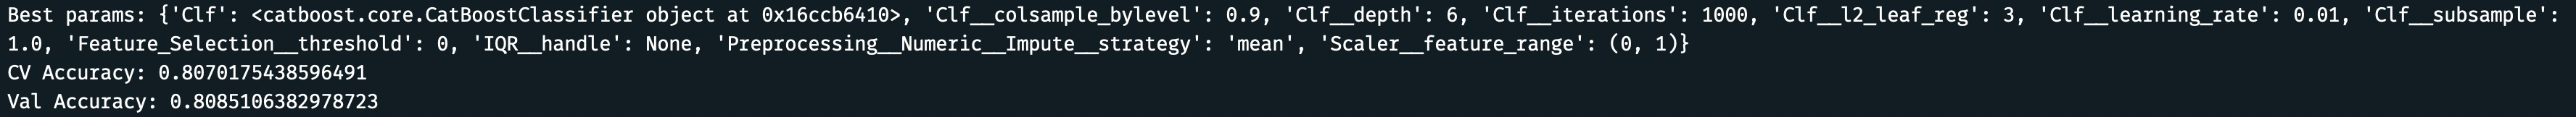

The gridsearch file automatically creates and saves predictions of the best model. While an increase from an accuracy of **0.8050** to **0.8085** does not seem like much, it is noteworthy that the "real" increase is far more substantial than that. Due to the iterative nature of Machine Learning, the above steps have all come together through a series of testing and model validation. Ultimately, the goal was to achieve the best performance possible using baseline models, do hyperparameter tuning on the best candidates, and then do further micro-experimentation with the best model. For example, this is how we found out that **stratisfied sampling** actually increases the performance of our models by a lot. Prior to that, even CatBoost was below 0.8 accuracy.

## Bonus: ANN Representations + Classifier
Despite intense preprocessing, we were curious to explore if feature representations from a Neural Network would boost our classifer even more!

**SPOILER: They dont :-(**

In [42]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.001))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
x = tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
x = tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

2023-06-29 01:48:11.732430: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-06-29 01:48:11.732455: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-06-29 01:48:11.732460: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-06-29 01:48:11.732491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-29 01:48:11.732505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44)]              0         
                                                                 
 dense (Dense)               (None, 64)                2880      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                            

In [44]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_val, y_val), callbacks=[earlystop], verbose=0)

2023-06-29 01:48:12.594218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-29 01:48:24.058580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


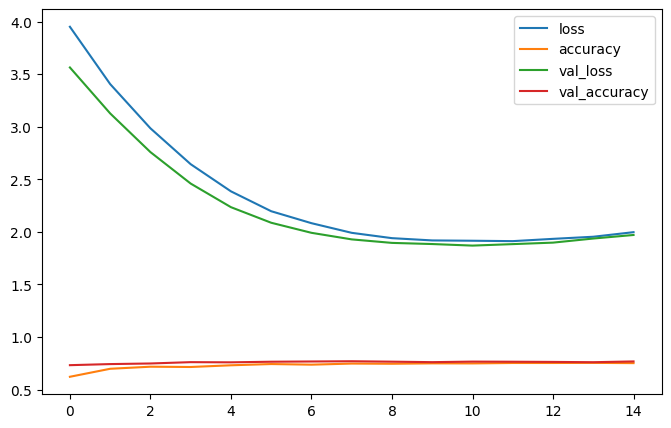

In [45]:
pd.DataFrame(model.history.history).plot(figsize=(8, 5));

In [46]:
inp = model.input
get_batch_output = tf.keras.backend.function([inp], [model.layers[-2].output])
batch_output = get_batch_output([X_train])[0]
batch_output

array([[0.74380386, 0.        , 0.        , ..., 0.67732424, 0.12187225,
        0.32204464],
       [3.6941621 , 0.        , 0.        , ..., 3.266416  , 0.5967679 ,
        2.232311  ],
       [3.6160336 , 0.        , 0.        , ..., 3.204887  , 0.59231466,
        2.2232175 ],
       ...,
       [0.0219718 , 0.06453158, 0.15991563, ..., 0.        , 0.20246437,
        0.        ],
       [2.931134  , 0.        , 0.        , ..., 2.594295  , 0.47915083,
        1.7783942 ],
       [1.1635951 , 0.        , 0.        , ..., 1.1672072 , 0.3037078 ,
        0.9790931 ]], dtype=float32)

In [47]:
ann_xgb = XGBClassifier()
ann_logreg = LogisticRegression()
ann_dt = DecisionTreeClassifier()
ann_rf = RandomForestClassifier()
ann_cat = CatBoostClassifier(verbose=False)

ann_xgb.fit(batch_output, y_train)
ann_logreg.fit(batch_output, y_train)
ann_dt.fit(batch_output, y_train)
ann_rf.fit(batch_output, y_train)
ann_cat.fit(batch_output, y_train)

In [48]:
ann_xgb_train_preds = ann_xgb.predict(batch_output)
ann_logreg_train_preds = ann_logreg.predict(batch_output)
ann_dt_train_preds = ann_dt.predict(batch_output)
ann_rf_train_preds = ann_rf.predict(batch_output)
ann_cat_train_preds = ann_cat.predict(batch_output)

In [49]:
print(f"Train accuracy for XGB: {accuracy_score(y_train, ann_xgb_train_preds)}")
print(f"Train accuracy for LogReg: {accuracy_score(y_train, ann_logreg_train_preds)}")
print(f"Train accuracy for DT: {accuracy_score(y_train, ann_dt_train_preds)}")
print(f"Train accuracy for RF: {accuracy_score(y_train, ann_rf_train_preds)}")
print(f"Train accuracy for Cat: {accuracy_score(y_train, ann_cat_train_preds)}")

Train accuracy for XGB: 0.8625251653724475
Train accuracy for LogReg: 0.7572620074777107
Train accuracy for DT: 0.9384526890997987
Train accuracy for RF: 0.9383088869715271
Train accuracy for Cat: 0.810468794938165


In [50]:
val_batch = get_batch_output([X_val])[0]

In [51]:
ann_xgb_val_preds = ann_xgb.predict(val_batch)
ann_logreg_val_preds = ann_logreg.predict(val_batch)
ann_dt_val_preds = ann_dt.predict(val_batch)
ann_rf_val_preds = ann_rf.predict(val_batch)
ann_cat_val_preds = ann_cat.predict(val_batch)

In [52]:
print(f"Val accuracy for XGB: {accuracy_score(y_val, ann_xgb_val_preds)}")
print(f"Val accuracy for LogReg: {accuracy_score(y_val, ann_logreg_val_preds)}")
print(f"Val accuracy for DT: {accuracy_score(y_val, ann_dt_val_preds)}")
print(f"Val accuracy for RF: {accuracy_score(y_val, ann_rf_val_preds)}")
print(f"Val accuracy for Cat: {accuracy_score(y_val, ann_cat_val_preds)}")

Val accuracy for XGB: 0.7377803335250144
Val accuracy for LogReg: 0.7435307648073606
Val accuracy for DT: 0.7015526164462335
Val accuracy for RF: 0.7320299022426682
Val accuracy for Cat: 0.7377803335250144


Extensive testing has been done using NN Representations. However, the CatBoost model without any hyperparameter tuning still outperforms all other approaches and tested models as of now (and with tuned hyperparameters excels even more). Not only that, but CatBoost is also a comparatively more computationally efficient tree-based algorithm than the other tested methods in this notebook.

# Outcome

As of 28/06/2023, the best position achieved is rank **299/2649** using the optimized CatBoost Pipeline with tuned hyperparameters obtained during Cross-Validated GridSearch, achieving an accuracy score of **0.80851** on the test dataset provided by kaggle.

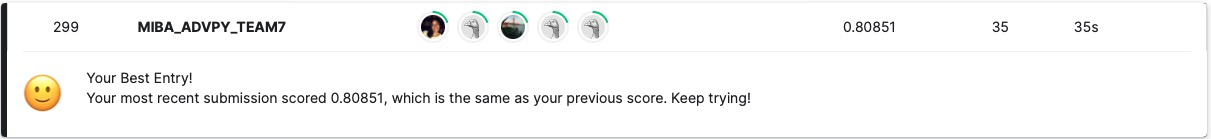

### The best preprocessing and model pipeline that lead to our results are summarized below.

<u>Preprocessing:</u>
- Impute Numeric Variables using mean
- Impute categorical variables with mode
- MinMax Scale: (0, 1)
- Apply Outlier removal (IQR): No
- Variance Threshold: 0

<u>Model (CatBoost Classifier) Hyperparameters:</u>
- colsample_bylevel: 0.9
- depth: 6
- iterations: 1000
- l2_leaf_reg: 3
- learning_rate: 0.01
- subsample: 1

<u>Further factors that lead to significant performance increases:</u>
- train_test_split: Stratified Sampling
- Feature Engineering: Filling NAN values in Homeplanet based on passenger Cabin Type
- Feature Engineering: Creating age bins
- Feature Engineering: Calculating Passenger Group Size